In [1]:
import numpy as np
from PIL import Image, ImageOps, ImageEnhance
import os
import math
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from random import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import shutil
import random

# Augmentation operations and list

In [2]:
IMAGE_SIZE = 32


def int_parameter(level, maxval):
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  return float(level) * maxval / 10.

def sample_level(n):
  return np.random.uniform(low=0.1, high=n)

def vipaug_g_prep(img, _):
        kernel = 2 #cifar is 2, imagenet is dunno
        vital = 0.005 #cifar10: 0.001, cifar100: 0.005, imagenet:  0.001
        nonvital = 0.012 #cifar10: 0.014, cifar100: 0.012, imagenet:  0.005
        fft = np.fft.fftn(img)
        absolute = np.abs(fft)
        noise_phase = np.zeros((np.shape(img)[0],np.shape(img)[1],np.shape(img)[2]))
        # kernel filter
        for p in range(3):
            index_list = []
            for i in range(len(absolute[:,:,p])//kernel):
                for j in range(len(absolute[:,:,p])//kernel):
                    number_list = []

                    for k2 in range(kernel):
                        for k1 in range(kernel):
                            number_list.append(absolute[:,:,p][kernel*i + k2, kernel*j + k1])

                    index = number_list.index(max(number_list))
                    k3 = index // kernel
                    k4 = index % kernel

                    #save index
                    index_x = kernel*i + k3
                    index_y = kernel*j + k4
                    index_list.append(np.array([index_x,index_y]))

            #make ones matrix
            mask = np.ones((np.shape(img)[0],np.shape(img)[1]))
            #make masked matrix
            for i1 in range(len(index_list)):
                mask[index_list[i1][0],index_list[i1][1]] = 0

            #add gaussian noise at phase
            mask_vital = mask - np.ones((np.shape(img)[0],np.shape(img)[1]))
            mask_vital = mask_vital * (-1)

            gaussian_noise_vital = np.random.normal(0,vital**0.5,(np.shape(img)[0],np.shape(img)[1]))
            gaussian_noise = np.random.normal(0,nonvital**0.5,(np.shape(img)[0],np.shape(img)[1]))
            masked_gaussian_noise = mask * gaussian_noise

            masked_gaussian_noise_vital = mask_vital * gaussian_noise_vital
            noise_phase[:,:,p] = np.angle(fft[:,:,p]) + masked_gaussian_noise + masked_gaussian_noise_vital

        return noise_phase

def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

def nothing(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return pil_img

def vipaug_g(x, _):
        op = np.random.choice(augmentations_vipaug_list)
        # print("first:", op)
        fft_before = np.fft.fftn(x)
        x = op(x, 3)

        x_aug = x.copy()
        op = np.random.choice(augmentations_vipaug_list)
        # print("second:",op)
        x_aug = op(x_aug, 3)

        x = np.array(x).astype(np.uint8)
        x_aug = np.array(x_aug).astype(np.uint8)

        fft_1 = np.fft.fftn(x)

        fft_2 = np.fft.fftn(x_aug)
        # print("Difference between fft_1 and fft_2 (after phase swap):", np.abs(fft_1 - fft_2).mean())

        p = random.uniform(0, 1)
        if p > 0.5: #VIPAug-G probability
            # print("first pass!", p)
            abs_1, angle_1 = np.abs(fft_1), np.angle(fft_1)
            abs_2, angle_2 = np.abs(fft_2), np.angle(fft_2)

            fft_1 = abs_1*np.exp((1j) * angle_2)
            fft_2 = abs_2*np.exp((1j) * angle_1)
            # print("First pass fft_1 and fft_2:", np.abs(fft_1 - fft_2).mean())

            p = random.uniform(0, 1)
            # print("in first pass", p)

            if p > 0.5:
                x = np.fft.ifftn(fft_1)
            else:
                x = np.fft.ifftn(fft_2)

        else:
            p = random.uniform(0, 1)
            # print("second pass!", p)
            if p > 0.5:
                # print("third pass!", p)
                angle_2 = vipaug_g_prep(x_aug, _)
                fft_1 = np.abs(fft_1)*np.exp((1j) * angle_2)
                x = np.fft.ifftn(fft_1)
            else:
                # print("fourth pass!", p)
                angle_1 = vipaug_g_prep(x, _)
                fft_2 = np.abs(fft_2)*np.exp((1j) * angle_1)
                x = np.fft.ifftn(fft_2)

        x = np.real(x)
        x = np.clip(x, 0, 255).astype(np.uint8)
        x = Image.fromarray(x)

        return x

augmentations_vipaug_list = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y]

augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, vipaug_g, color, contrast, brightness, sharpness]

In [ ]:
image, label = train_data[11]
augie_mage = aug(image, preprocess)
inv_normalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)
augie_mage = inv_normalize(augie_mage).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(image)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(augie_mage)
ax2.set_title("VipAug")
ax2.axis('off')

plt.tight_layout()
plt.show()

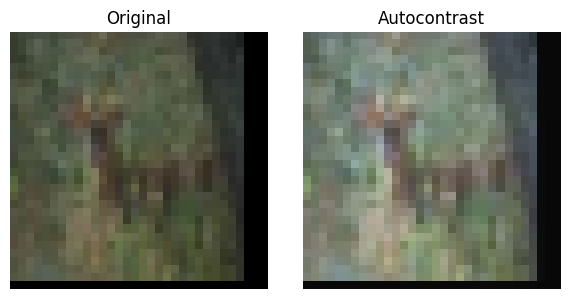

In [ ]:
image, label = train_data[10]
aug_image = aug(image, preprocess)
inv_normalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

# Undo normalization and convert to numpy
aug_image = inv_normalize(aug_image).clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(image)
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(aug_image)
ax2.set_title("Autocontrast")
ax2.axis('off')

plt.tight_layout()
plt.show()

# Mix augmentations final image

In [3]:
def aug(image, preprocess):
  """Perform AugMix augmentations and compute mixture.

  Args:
    image: PIL.Image input image
    preprocess: Preprocessing function which should return a torch tensor.

  Returns:
    mixed: Augmented and mixed image.
  """
  aug_list = augmentations

  ws = np.float32(np.random.dirichlet([1] * 3))
  m = np.float32(np.random.beta(1, 1))

  mix = torch.zeros_like(preprocess(image))
  for i in range(3):
    image_aug = image.copy()
    depth = -1 if -1 > 0 else np.random.randint(
        1, 4)
    # print("depth:", depth)
    for _ in range(depth):
      op = np.random.choice(aug_list)
      # print("aug combinations:", op)
      image_aug = op(image_aug, 3)
    # Preprocessing commutes since all coefficients are convex
    mix += ws[i] * preprocess(image_aug)

  mixed = (1 - m) * preprocess(image) + m * mix
  return mixed

# Make Dataset out of augmentations

In [4]:
class AugMixDataset(torch.utils.data.Dataset):
  """Dataset wrapper to perform AugMix augmentation."""

  def __init__(self, dataset, preprocess, no_jsd=True):
    self.dataset = dataset
    self.preprocess = preprocess
    self.no_jsd = no_jsd

  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.no_jsd:
      return aug(x, self.preprocess), y
    else:
      im_tuple = (self.preprocess(x), aug(x, self.preprocess),
                  aug(x, self.preprocess))
      return im_tuple, y

  def __len__(self):
    return len(self.dataset)

# Training and Test function

In [5]:
def train(net, train_loader, optimizer, scheduler, no_jsd=True, print_freq=100):
  """Train for one epoch."""
  net.train()
  loss_ema = 0.
  for i, (images, targets) in enumerate(train_loader):
    optimizer.zero_grad()

    if no_jsd:
      images = images.cuda()
      targets = targets.cuda()
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
    else:
      images_all = torch.cat(images, 0).cuda()
      targets = targets.cuda()
      logits_all = net(images_all)
      logits_clean, logits_aug1, logits_aug2 = torch.split(
          logits_all, images[0].size(0))

      # Cross-entropy is only computed on clean images
      loss = F.cross_entropy(logits_clean, targets)

      p_clean, p_aug1, p_aug2 = F.softmax(
          logits_clean, dim=1), F.softmax(
              logits_aug1, dim=1), F.softmax(
                  logits_aug2, dim=1)

      # Clamp mixture distribution to avoid exploding KL divergence
      p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
      loss += 12 * (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                    F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.

    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_ema = loss_ema * 0.9 + float(loss) * 0.1
    if i % args.print_freq == 0:
      print('Train Loss {:.3f}'.format(loss_ema))

  return loss_ema

In [6]:
def test(net, test_loader):
  """Evaluate network on given dataset."""
  net.eval()
  total_loss = 0.
  total_correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images, targets = images.cuda(), targets.cuda()
      logits = net(images)
      loss = F.cross_entropy(logits, targets)
      pred = logits.data.max(1)[1]
      total_loss += float(loss.data)
      total_correct += pred.eq(targets.data).sum().item()

  return total_loss / len(test_loader.dataset), total_correct / len(
      test_loader.dataset)

def test_c(net, test_data, base_path):
  """Evaluate network on given corrupted dataset."""
  corruption_accs = []
  for corruption in CORRUPTIONS:
    # Reference to original data is mutated
    test_data.data = np.load(base_path + corruption + '.npy')
    test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=args.eval_batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True)

    test_loss, test_acc = test(net, test_loader)
    corruption_accs.append(test_acc)
    print('{}\n\tTest Loss {:.3f} | Test Error {:.3f}'.format(
        corruption, test_loss, 100 - 100. * test_acc))

  return np.mean(corruption_accs)

# Model architecture

In [7]:
class BasicBlock(nn.Module):
  """Basic ResNet block."""

  def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
    super(BasicBlock, self).__init__()
    self.bn1 = nn.BatchNorm2d(in_planes)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv1 = nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)
    self.bn2 = nn.BatchNorm2d(out_planes)
    self.relu2 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(
        out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.drop_rate = drop_rate
    self.is_in_equal_out = (in_planes == out_planes)
    self.conv_shortcut = (not self.is_in_equal_out) and nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=1,
        stride=stride,
        padding=0,
        bias=False) or None

  def forward(self, x):
    if not self.is_in_equal_out:
      x = self.relu1(self.bn1(x))
    else:
      out = self.relu1(self.bn1(x))
    if self.is_in_equal_out:
      out = self.relu2(self.bn2(self.conv1(out)))
    else:
      out = self.relu2(self.bn2(self.conv1(x)))
    if self.drop_rate > 0:
      out = F.dropout(out, p=self.drop_rate, training=self.training)
    out = self.conv2(out)
    if not self.is_in_equal_out:
      return torch.add(self.conv_shortcut(x), out)
    else:
      return torch.add(x, out)


class NetworkBlock(nn.Module):
  """Layer container for blocks."""

  def __init__(self,
               nb_layers,
               in_planes,
               out_planes,
               block,
               stride,
               drop_rate=0.0):
    super(NetworkBlock, self).__init__()
    self.layer = self._make_layer(block, in_planes, out_planes, nb_layers,
                                  stride, drop_rate)

  def _make_layer(self, block, in_planes, out_planes, nb_layers, stride,
                  drop_rate):
    layers = []
    for i in range(nb_layers):
      layers.append(
          block(i == 0 and in_planes or out_planes, out_planes,
                i == 0 and stride or 1, drop_rate))
    return nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)


class WideResNet(nn.Module):
  """WideResNet class."""

  def __init__(self, depth, num_classes, widen_factor=1, drop_rate=0.0):
    super(WideResNet, self).__init__()
    n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
    assert (depth - 4) % 6 == 0
    n = (depth - 4) // 6
    block = BasicBlock
    # 1st conv before any network block
    self.conv1 = nn.Conv2d(
        3, n_channels[0], kernel_size=3, stride=1, padding=1, bias=False)
    # 1st block
    self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, 1,
                               drop_rate)
    # 2nd block
    self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2,
                               drop_rate)
    # 3rd block
    self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2,
                               drop_rate)
    # global average pooling and classifier
    self.bn1 = nn.BatchNorm2d(n_channels[3])
    self.relu = nn.ReLU(inplace=True)
    self.fc = nn.Linear(n_channels[3], num_classes)
    self.n_channels = n_channels[3]

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.bias.data.zero_()

  def forward(self, x):
    out = self.conv1(x)
    out = self.block1(out)
    out = self.block2(out)
    out = self.block3(out)
    out = self.relu(self.bn1(out))
    out = F.avg_pool2d(out, 8)
    out = out.view(-1, self.n_channels)
    return self.fc(out)

# Model settings

In [8]:
class Args:
    dataset = 'cifar100'  # or 'cifar100'
    model = 'wrn'  # 'densenet', 'wrn', 'allconv', 'resnext'
    batch_size = 128
    eval_batch_size = 1000
    num_workers = 0
    no_jsd = True
    layers = 40
    widen_factor = 2
    droprate = 0.0
    learning_rate = 0.1
    momentum = 0.9
    decay = 0.0005
    epochs = 50
    print_freq = 100
    resume = None  # path to checkpoint
    evaluate = True
    save = './checkpoints'

args = Args()

def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 42
setup_seed(seed)

In [9]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4)
])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])
test_transform = preprocess

if args.dataset == 'cifar10':
    train_data = datasets.CIFAR10('./data/cifar', train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10('./data/cifar', train=False, transform=test_transform, download=True)
    base_c_path = './CIFAR-10-C/'
    num_classes = 10
else:
    train_data = datasets.CIFAR100('./data/cifar', train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR100('./data/cifar', train=False, transform=test_transform, download=True)
    base_c_path = './CIFAR-100-C/'
    num_classes = 100


100%|██████████| 169M/169M [00:18<00:00, 9.18MB/s]


In [10]:
train_data = AugMixDataset(train_data, preprocess, args.no_jsd)
train_loader = torch.utils.data.DataLoader(
      train_data,
      batch_size=args.batch_size,
      shuffle=True,
      num_workers=args.num_workers,
      pin_memory=True)

test_loader = torch.utils.data.DataLoader(
      test_data,
      batch_size=args.eval_batch_size,
      shuffle=False,
      num_workers=args.num_workers,
      pin_memory=True)

In [11]:
CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]
def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
net = WideResNet(args.layers, num_classes, args.widen_factor, args.droprate)

optimizer = torch.optim.SGD(
      net.parameters(),
      args.learning_rate,
      momentum=args.momentum,
      weight_decay=args.decay,
      nesterov=True)

net = torch.nn.DataParallel(net).cuda()
cudnn.benchmark = True

scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
          step,
          args.epochs * len(train_loader),
          1,  # lr_lambda computes multiplicative factor
          1e-6 / args.learning_rate))

In [12]:
start_epoch = 0
best_acc = 0
if args.resume and os.path.isfile(args.resume):
    checkpoint = torch.load(args.resume)
    start_epoch = checkpoint['epoch'] + 1
    best_acc = checkpoint['best_acc']
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print(f'Model restored from epoch {start_epoch}')

In [13]:
if not os.path.exists(args.save):
    os.makedirs(args.save)

log_path = os.path.join(args.save, f'{args.dataset}_{args.model}_training_log.csv')
with open(log_path, 'w') as f:
    f.write('epoch,time(s),train_loss,test_loss,test_error(%)\n')

print(f'Starting training from epoch {start_epoch + 1}')
for epoch in range(start_epoch, args.epochs):
    begin_time = time.time()

    train_loss_ema = train(net, train_loader, optimizer, scheduler)
    test_loss, test_acc = test(net, test_loader)

    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)

    checkpoint = {
        'epoch': epoch,
        'dataset': args.dataset,
        'model': args.model,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }

    save_path = os.path.join(args.save, 'checkpoint.pth.tar')
    torch.save(checkpoint, save_path)
    if is_best:
        shutil.copyfile(save_path, os.path.join(args.save, 'model_best.pth.tar'))

    with open(log_path, 'a') as f:
        f.write(f'{epoch+1:03d},{int(time.time() - begin_time):05d},{train_loss_ema:.6f},{test_loss:.5f},{100 - 100. * test_acc:.2f}\n')

    print(f'Epoch {epoch+1:3d} | Time {int(time.time() - begin_time):5d}s | '
          f'Train Loss {train_loss_ema:.4f} | Test Loss {test_loss:.3f} | '
          f'Test Error {100 - 100. * test_acc:.2f}%')

Starting training from epoch 1
Train Loss 0.464
Train Loss 4.178
Train Loss 3.991
Train Loss 3.826
Epoch   1 | Time   168s | Train Loss 3.6505 | Test Loss 0.004 | Test Error 85.31%
Train Loss 0.363
Train Loss 3.515
Train Loss 3.335
Train Loss 3.260
Epoch   2 | Time   161s | Train Loss 3.0789 | Test Loss 0.003 | Test Error 79.06%
Train Loss 0.320
Train Loss 2.984
Train Loss 2.944
Train Loss 2.783
Epoch   3 | Time   160s | Train Loss 2.6586 | Test Loss 0.003 | Test Error 73.05%
Train Loss 0.242
Train Loss 2.578
Train Loss 2.590
Train Loss 2.450
Epoch   4 | Time   157s | Train Loss 2.4483 | Test Loss 0.003 | Test Error 70.99%
Train Loss 0.239
Train Loss 2.348
Train Loss 2.299
Train Loss 2.341
Epoch   5 | Time   157s | Train Loss 2.2125 | Test Loss 0.002 | Test Error 61.70%
Train Loss 0.234
Train Loss 2.135
Train Loss 2.092
Train Loss 2.086
Epoch   6 | Time   155s | Train Loss 2.1316 | Test Loss 0.002 | Test Error 56.90%
Train Loss 0.221
Train Loss 2.026
Train Loss 1.962
Train Loss 2.018
E

In [14]:
if args.evaluate:
    test_loss, test_acc = test(net, test_loader)
    print(f'Clean\n\tTest Loss {test_loss:.3f} | Test Accuracy {test_acc * 100:.2f}%')

Clean
	Test Loss 0.001 | Test Accuracy 74.44%


In [15]:
test_c_acc = test_c(net, test_data, base_c_path)
print(f'Mean Corruption Error: {100 - 100. * test_c_acc:.2f}%')

with open(log_path, 'a') as f:
    f.write(f'{args.epochs + 1:03d},00000,0.000000,0.00000,{100 - 100 * test_c_acc:.2f}\n')

gaussian_noise
	Test Loss 0.003 | Test Error 57.310
shot_noise
	Test Loss 0.002 | Test Error 49.702
impulse_noise
	Test Loss 0.002 | Test Error 46.224
defocus_blur
	Test Loss 0.001 | Test Error 29.158
glass_blur
	Test Loss 0.003 | Test Error 63.708
motion_blur
	Test Loss 0.001 | Test Error 34.154
zoom_blur
	Test Loss 0.001 | Test Error 32.562
snow
	Test Loss 0.002 | Test Error 41.130
frost
	Test Loss 0.002 | Test Error 44.958
fog
	Test Loss 0.002 | Test Error 35.568
brightness
	Test Loss 0.001 | Test Error 28.774
contrast
	Test Loss 0.002 | Test Error 40.604
elastic_transform
	Test Loss 0.002 | Test Error 36.722
pixelate
	Test Loss 0.002 | Test Error 42.072
jpeg_compression
	Test Loss 0.002 | Test Error 46.818
Mean Corruption Error: 41.96%
